[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-15-2b56868fb022>:13: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train = pd.read_csv('EI-oc-En-anger-train.txt', sep='\t', error_bad_lines=False)
<ipython-input-15-2b56868fb022>:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dev = pd.read_csv('2018-EI-oc-En-anger-dev.txt', sep='\t', error_bad_lines=False)
<ipython-input-15-2b56868fb022>:17: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test= pd.read_csv("2018-EI-oc-En-anger-test.txt", sep='\t', error_bad_lines=False)


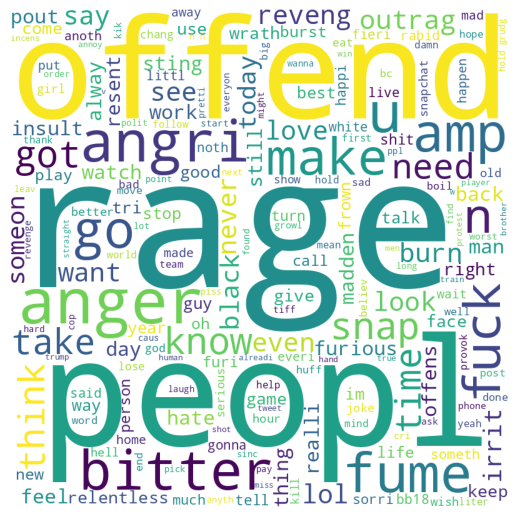

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           1300000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 128)          63744     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                      

In [ ]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
nltk.download('stopwords')
from keras.utils import pad_sequences


#import dataset as dataframe

train = pd.read_csv('EI-oc-En-anger-train.txt', sep='\t', error_bad_lines=False)
train.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"]
dev = pd.read_csv('2018-EI-oc-En-anger-dev.txt', sep='\t', error_bad_lines=False)
dev.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"]
test= pd.read_csv("2018-EI-oc-En-anger-test.txt", sep='\t', error_bad_lines=False)
test.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"]

train['Intensity_Class'] = pd.Categorical(train['Intensity_Class'])
train['Intensity_Class'] =train.Intensity_Class.cat.codes

dev['Intensity_Class'] = pd.Categorical(dev['Intensity_Class'])
dev['Intensity_Class'] = dev.Intensity_Class.cat.codes

test['Intensity_Class'] = pd.Categorical(test['Intensity_Class'])
test['Intensity_Class'] = test.Intensity_Class.cat.codes



stop_words = set(stopwords.words('english'))
stop_words.update(["now","let", 'zero', 'one', 'two', 'three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)



#Removing Stop Words

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

train['Tweet'] = train['Tweet'].apply(removeStopWords)
test['Tweet'] = test['Tweet'].apply(removeStopWords)
dev['Tweet'] = dev['Tweet'].apply(removeStopWords)



#Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train['Tweet'] = train['Tweet'].apply(stemming)
dev['Tweet'] = dev['Tweet'].apply(stemming)
test['Tweet'] = test['Tweet'].apply(stemming)

from wordcloud import WordCloud

# Combine the training data into a single string
train_text = ' '.join(train['Tweet'])

# Generate a word cloud from the training data
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(train_text)

# Plot the word cloud
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



from keras.utils import to_categorical
target=train.Intensity_Class.values
y=to_categorical(target)

target=dev.Intensity_Class.values
c=to_categorical(target)



max_features = 13000
max_words = 50
batch_size = 128
epochs = 3
num_classes=4


X_train = train["Tweet"]
X_val = dev["Tweet"]
Y_train = y
Y_val = c

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,GRU,Embedding
from keras.layers import SpatialDropout1D,Bidirectional
import matplotlib.pyplot as plt
from collections import Counter

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

X_test = tokenizer.texts_to_sequences(test['Tweet'])
X_test =pad_sequences(X_test, maxlen=max_words)



X_train =pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)
X_test =pad_sequences(X_test, maxlen=max_words)


model4_BGRU = Sequential()
model4_BGRU.add(Embedding(max_features, 100, input_length=max_words))
model4_BGRU.add(SpatialDropout1D(0.25))
model4_BGRU.add(Bidirectional(GRU(64,dropout=0.4,return_sequences = True)))
model4_BGRU.add(Bidirectional(GRU(32,dropout=0.5,return_sequences = False)))
model4_BGRU.add(Dense(4, activation='sigmoid'))
model4_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_BGRU.summary()

history4=model4_BGRU.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)


In [ ]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
model = Sequential()
model.add(Embedding(10000, 100, input_length=max_words))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history4=model.fit(X_train, Y_train, validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1)


Epoch 1/3
14/14 [==============================] - 2s 66ms/step - loss: 1.3762 - accuracy: 0.2975 - val_loss: 1.3666 - val_accuracy: 0.2500
Epoch 2/3
14/14 [==============================] - 1s 59ms/step - loss: 1.3560 - accuracy: 0.2992 - val_loss: 1.3618 - val_accuracy: 0.2500
Epoch 3/3
14/14 [==============================] - 1s 88ms/step - loss: 1.3124 - accuracy: 0.3157 - val_loss: 1.3558 - val_accuracy: 0.2474
